# CH03. 평가

성능평가지표(Evaluation metric)는 일반적으로 모델이 분류냐, 회귀냐에 따라 여러 종류로 나뉨. 
* 회귀의 경우 대부분 mean(실제값-예측값)에 기반.
* 분류는 이진분류와 멀티분류로 나뉘는데, <br> 본 장에서는 분류에 사용되는 성능 평가 지표, 그 중에서도 0과 1로 결정값이 한정되는 이진 분류의 성능 평가 지표에 대해 집중적으로 설명. (이진분류에서는 정확도보다 다른 성능 평가 지표가 더 중시되는 경우가 많음)


분류의 성능평가지표
1. 정확도(Accuracy)
2. 오차행렬(Confusion Matrix)
3. 정밀도(Precision)
4. 재현율(Recall)
5. F1 스코어
6. ROC AUC



## 정확도(Accuracy)

정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

이진 분류의 경우 데이터의 구성에 따라(특히 불형한 레이블 값 분포에서) ML모델의 성능을 왜곡할 수 있음. 
-> 수치 하나만 가지고 성능을 평가하지 X

In [5]:
# MNIST 데이터셋 예시

from sklearn.datasets import load_digits # MNIST dataset 로드
from sklearn.model_selection import train_test_split
# 사이킷런은 BaseEstimator를 상속받으면 Customized된 Estimator 개발 가능
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator) : 
    # 아무것도 학습하지 않음
    def fit(self,X,y) :
        pass
    
    # 입력값으로 들어오는 X 데이터셋 크기만큼 모두 0으로 된 배열 반환
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    

In [6]:
digits=load_digits()

In [11]:
print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape:", digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)


target: {ndarray, Series} of shape (1797,)<br>
The classification target. If `as_frame=True`, target will be a pandas Series.

In [7]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [8]:
digits.target == 7

array([False, False, False, ..., False, False, False])

In [9]:
#digits 번호가 7번이면 True, 이를 astype(int)로 1로 변환. 7이 아니면 0으로 변환 -> 불균형한 data 생성
y= (digits.target==7).astype(int)

In [10]:
X_train,X_test, y_train,y_test = train_test_split(digits.data,y,random_state=11)

In [12]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64


In [13]:
# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

모든 예측을 0으로 하여도 정확도는:0.900


정확도가 가지는 분류 평가 지표로서의 한계점을 극복하기 위해 여러가지 분류 지표와 함께 적용해야! 

## 오차행렬(혼동행렬, Confusion Matrix)

: 이진 분류의 예측 오류가 얼마인지 + 어떠한 유형의 예측 오류가 발생하고 있는지 함께 나타내는 지표

4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냄. 
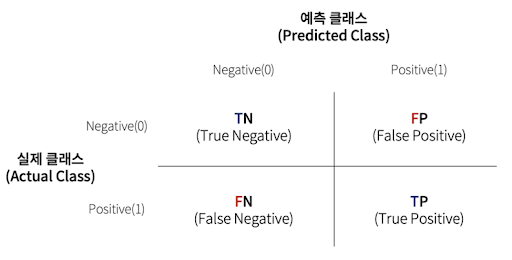

* True/False는 예측값과 실제값이 같은지/틀린지
* Negative/Positive는 예측 결과값이 긍정(1,True)인지 부정(0,False)인지

사이킷런은 오차행렬을 구하는 `confusion_matrix()` API를 제공.

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

* 출력된 오차행렬은 `ndarray` 형태. 
* 앞선 데이터는 모두 0(Negative)로 예측했으므로 ~T 가 없음.
* [[TN, FP],<br>[FN,TP]]   -> 이 값을 조합해 `정확도/정밀도/재현율` 계산

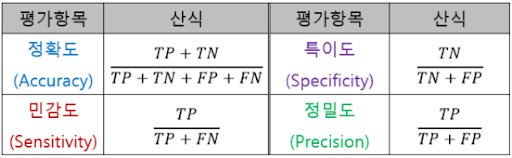


1. 정확도 = (TP+TN) / (TP+TN+FP+FN) = 예측 결과와 실제가 동일 / 전체
    * 정확도의 경우, T~ 의 비율만 측정. 

일반적으로 찾아내야 하는 데이터 값을 Positive(1)로 설정-> 불균형한 이진 분류 데이터셋에서는 Positive 데이터 건수가 작기 때문에 Negative 예측 정확도가 상대적으로 높아지는 경향이 발생함. -> 정확도 지표는 비대칭한 데이터셋에서 negative에 대한 예측 정확도만으로 분류 정확도가 매우 높게 나타나는 판단 오류가 발생할 수 있음. 

## 정밀도(Precision) 과 재현율(Recall)

-> Positive 데이터셋 예측 성능에 좀 더 초점을 맞춘 평가 지표. 불균형한 데이터셋 정확도 평가에서 선호됨.

2. 정밀도 = TP/(FP+TP) = Positive로 예측한 데이터 중 실제로 일치한 비율
    * Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가지표 (=양성예측도)
    * 실제 Negative 데이터를 Positive로 잘못 판단하면 안되는 경우에 중요.<br> 예) 스팸메일
    * `precision_score()`


3. 재현율 = TP/(FN+TP) = 실제 값이 Positive인 대상 중 예측을 맞게 한 비율
    * = 민감도 = True Positive Rate(TPR)
    * Positive를 Negative로 잘못 판단하면 안되는 경우에 중요.<br> 예) 암 진단, 금융 사기
    * `recall_score()`


재현율과 정밀도 모두 TP를 높이는 데 초점을 맞추지만, 정밀도는 FP를 낮추는 게, 재현율은 FN을 낮추는 게 중요. -> 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는데 적용.(둘 다 높은 수치를 얻는 것이 목표)

In [16]:
#평가 지표를 한꺼번에 호출하는 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))


In [17]:
#2장 참고
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

#로지스틱 회귀로 분류를 수행
# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('..\\titanic\\data\\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, \
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\Users\Yujin\anaconda3\envs\dsvenv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Precision/Recall Trade-off

Q. 재현율 또는 정밀도를 강화할 방법? -> A. 분류의 결정 임곗값(Threshold)을 조정<br>
but 정밀도와 재현율은 상호보완적인 지표라 어느 한쪽을 강제로 높이면 다른 한쪽이 낮아짐.

사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블의 결정 확률을 구한다. -> 그 후 예측 확률이 큰 레이블 값으로 예측, 일반적으로 이진 분류엣는 임곗값이 0.5(50%)로 정하고 이 기준보다 크면 positive, 작으면 negative.

* `predict__proba()` : 개별 데이터별로 예측 확률을 반환
    * 이진분류에서 수행하면 반환되는 ndarray 첫번째 칼럼이 레이블 값 0에 대한 예측 확률, 두번째 칼럼이 1에 대한 예측 확률.

In [20]:
lr_clf.predict_proba(X_test)

array([[0.46183897, 0.53816103],
       [0.87859221, 0.12140779],
       [0.87724531, 0.12275469],
       [0.88288285, 0.11711715],
       [0.85510859, 0.14489141],
       [0.88235314, 0.11764686],
       [0.888365  , 0.111635  ],
       [0.20917725, 0.79082275],
       [0.78251391, 0.21748609],
       [0.37001066, 0.62998934],
       [0.89992887, 0.10007113],
       [0.87476404, 0.12523596],
       [0.87723948, 0.12276052],
       [0.8883202 , 0.1116798 ],
       [0.43480605, 0.56519395],
       [0.85882444, 0.14117556],
       [0.90375248, 0.09624752],
       [0.73307835, 0.26692165],
       [0.72424378, 0.27575622],
       [0.17230129, 0.82769871],
       [0.75331899, 0.24668101],
       [0.61950483, 0.38049517],
       [0.8544486 , 0.1455514 ],
       [0.81512657, 0.18487343],
       [0.88795848, 0.11204152],
       [0.76523718, 0.23476282],
       [0.85970901, 0.14029099],
       [0.92597538, 0.07402462],
       [0.71920226, 0.28079774],
       [0.69488431, 0.30511569],
       [0.

In [21]:
lr_clf.predict(X_test)

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1], dtype=int64)

In [22]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46183897 0.53816103]
 [0.87859221 0.12140779]
 [0.87724531 0.12275469]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46183897 0.53816103 1.        ]
 [0.87859221 0.12140779 0.        ]
 [0.87724531 0.12275469 0.        ]]


`predict()` 매서드는 `predict_proba()` 의 호출 결과로 반환된 배열에서 분류 결정 임계값(이진분류:0.5)보다 큰 값이 들어있는 컬럼을 받아서 최종적으로 예측 클래스를 결정. 

**Binarizer 활용**

In [23]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [24]:
#Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


lr_clf 객체의 지표 값과 같음. 

In [27]:
# Binarizer의 임계값을 낮추면? 0.5->0.4 
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


정밀도 낮아지고, 재현율 올라감. <br>
**why?** 0.4부터 positive로 예측하기 때문에 (예측을 너그럽게 함) True 값이 많아짐. 

In [32]:
# 임계값을 증가시키며 평가 지표를 조사

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장. 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,thresholds) :
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값 :',custom_threshold)
        get_clf_eval(y_test,custom_predict)
        
get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임계값 : 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361
임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


`precision_recall_curve()` API를 활용하면 `정밀도`와 `재현율` 값을 배열로 반환

|               |                                                                                                                                 |
|---------------|---------------------------------------------------------------------------------------------------------------------------------|
| **입력 파라미터** | `y_true`: 실제 클래스 값 배열(배열 크기 = [데이터 건수])<br>`probas_pred`: Positive 칼럼의 예측 확률 배열(배열크기 = [데이터 건수]) |
| **반환 값**       | `정밀도`: 임곗값별 정밀도 값을 배열로 반환<br>`재현율`: 임곗값별 재현율 값을 배열로 반환                                            |

In [36]:
# precision_recall_curve( ) 를 이용하여 임곗값에 따른 정밀도-재현율 값 추출
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("\nthresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

반환된 분류 결정 임곗값 배열의 Shape: (143,)
반환된 precisions 배열의 Shape: (144,)
반환된 recalls 배열의 Shape: (144,)

thresholds 5 sample: [0.10394913 0.10395132 0.10397586 0.10743271 0.10893724]
precisions 5 sample: [0.38853503 0.38461538 0.38709677 0.38961039 0.38562092]
recalls 5 sample: [1.         0.98360656 0.98360656 0.98360656 0.96721311]


In [38]:
thresholds

array([0.10394913, 0.10395132, 0.10397586, 0.10743271, 0.10893724,
       0.111635  , 0.11167116, 0.1116798 , 0.11204152, 0.11207522,
       0.11629164, 0.1169455 , 0.11711715, 0.11764686, 0.1179505 ,
       0.12140779, 0.12270151, 0.12275469, 0.1227557 , 0.12276052,
       0.12428602, 0.12523596, 0.12540704, 0.12658633, 0.1285023 ,
       0.12914444, 0.13049489, 0.13291906, 0.13307853, 0.13319244,
       0.14029099, 0.14117556, 0.14122148, 0.14122833, 0.14489141,
       0.1455514 , 0.14775322, 0.14775352, 0.14996151, 0.1531005 ,
       0.15440766, 0.16836611, 0.16870242, 0.183699  , 0.18487343,
       0.1864308 , 0.19688778, 0.19852318, 0.19874782, 0.21748609,
       0.22649991, 0.23223999, 0.233661  , 0.23476282, 0.24067484,
       0.24668101, 0.2502734 , 0.26692165, 0.27575622, 0.28051282,
       0.28079774, 0.30511569, 0.30918939, 0.30982677, 0.31715412,
       0.3205187 , 0.32162525, 0.34907318, 0.34919445, 0.35034486,
       0.35705773, 0.38021845, 0.38049517, 0.3987351 , 0.39945

In [37]:
#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]


In [39]:
# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


임계값이 증가할수록 정밀도 값은 동시에 높아지나, 재현율 값은 낮아짐. 

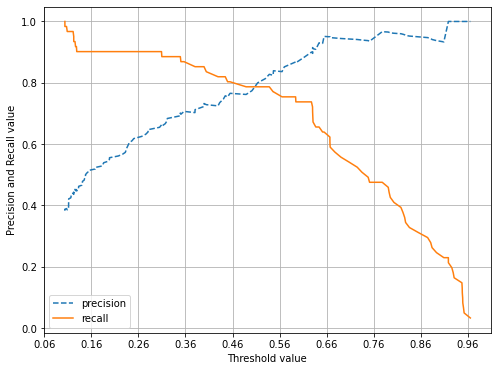

In [44]:
# 정밀도와 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test,pred_proba_c1) :
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행.
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

앞선 로지스틱 회귀 기반 예측모델에서와 같이 약 0.5 지점에서 재현율과 정밀도가 비슷해지는 모습을 보임. 

정밀도와 재현율 수치는 어느 한쪽만 참조하면 극단적인 수치 조작이 가능함. -> 둘 중 하나에 상대적인 중요도를 부여해 튜닝할 수는 있지만, 정밀도/재현율 중 하나만 강조하는 상황이 되어서는 안됨. 

## F1 Score

: 정밀도와 재현율을 결합한 지표(둘 중 어느 한쪽으로 치우치지 않을 때 높은 값)
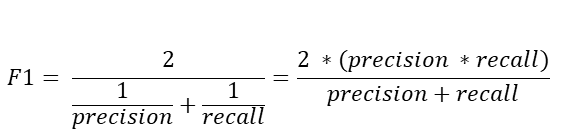



F1 score는 Precision과 Recall의 `조화평균`입니다. 

* 조화평균의 기하학적 접근

조화평균은 기하학적으로 다음과 같이 표현할 수 있습니다. 서로 다른 길이의 A, B와 이 두 길이의 합만큼 떨어진 변(AB)으로 이루어진 사다리꼴을 생각해봅시다. 이 AB에서 각 변의 길이가 만나는 지점으로부터 맞은 편의 사다리꼴의 변으로 내린 선분이 바로 조화평균을 나타냅니다.

<Fig5. 조화평균의 기하학적 의미>

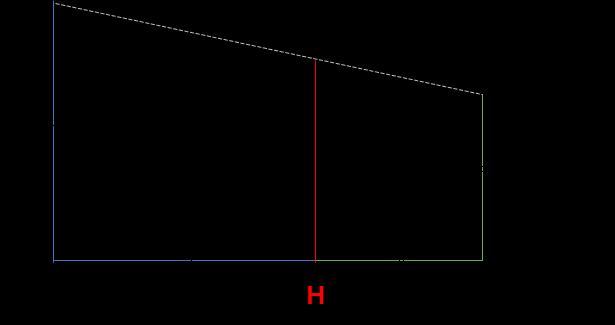

기하학적으로 봤을 때, 단순 평균이라기보다는 작은 길이 쪽으로 치우치게 된, 그러면서 작은 쪽과 큰 쪽의 사이의 값을 가진 평균이 도출됩니다. 이렇게 조화평균을 이용하면 산술평균을 이용하는 것보다, 큰 비중이 끼치는 bias가 줄어든다고 볼 수 있습니다. 즉, F1-score는 아래와 같이 생각할 수 있습니다.

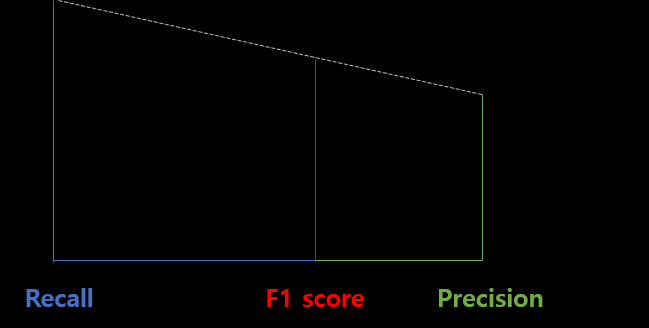

> 출처 : https://sumniya.tistory.com/26


<span style="color:red">**[질문]**</span><br>
??? 산술평균으로 구할 때보다 큰 값에 치우치지 않는다는 점은 알겠는데,,<br> 
이러한 계산법이 왜 recall과 precision간의 균형을 맞추는데 유리한지...?<br>  
추가 설명해줄 지훈/도영 찾습니다 ^-^

In [45]:
# 로지스틱 회귀에 기반한 f1 score
from sklearn.metrics import f1_score 

f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [46]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값 : 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1:0.7786
임계값 : 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임계값 : 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임계값 : 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임계값 : 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


F1 score는 임계값이 0.6일 때 가장 크지만, 이 경우 재현율이 크게 감소함. (주의)

<span style="color:red">**[질문]**</span><br>
> p.168

`F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가집니다.`

Q. 위의 결과값은 책의 설명에 모순되는 결과값 아닌가?,,,<br>
임계값 = 0.5에서 두 값의 차이가 가장 작은 것 같은데, f1스코어는 상대적으로 작은데...

## ROC Curve와 AUC

이진 분류 모델의 예측 성능 판단에 중요한 지표!
ROC 곡선 = FPR(False Positive Rate)이 변화할 때 TPR(True Positive Rate)이 어떻게 변화하는지

* TPR = 재현율 = 민감도 <-> TNR(True Negative Rate) = 특이성
* TNR = TN / (FP+TN)
* 민감도(TPR)는 Positeve가 정확히 예측되어야 하는 수준, 특이성(TNR)은 Negative가 정확히 예측되어야 하는 수준을 나타냄. 

따라서, ROC곡선의 X축인 FPR = 1- TNR = FP / (FP+TN) = FP/실제NEGATIVE


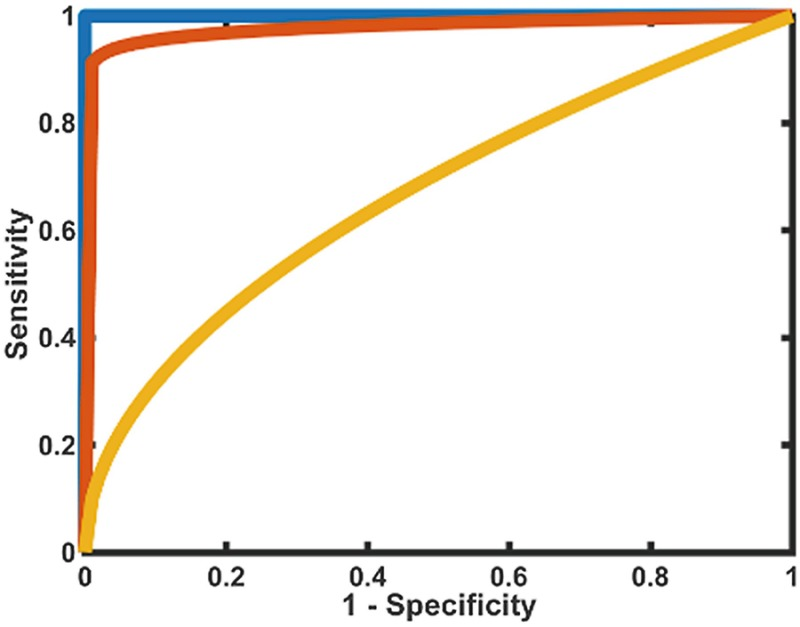

* 가운데 직선은 ROC곡선의 최저값
* ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어짐.
* FPR을 0~1까지 변화 <= 분류 결정 임계값을 변화
    * 임계값 = 1 이면 FPR 0
    * 임계값 = 0 이면 FPR 1

* `roc_curve()` 사용 

|               |                                                                                                                                                 |
|---------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| **입력 파라미터** | `y_true`: 실제 클래스 값 array(array shape = [데이터 건수])<br>`y_score`: predict_proba()의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용 |
| **반환 값**       | `fpr`: fpr 값을 array로 반환<br>`tpr`: tpr 값을 array로 반환<br>`thresholds`: thresholds 값 array                                                     |

<span style="color:red">**[질문]**</span><br>
`roc_curve()`의 입력값으로 `y_true`와 `y_score`와가 필요한 이유??

In [54]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
fprs,tprs,thresholds = roc_curve(y_test,pred_proba_class1)

print('max predict_proba:', np.max(pred_proba_class1))
print('threshold[0] :',thresholds[0])

#threshold[0]은 max(예측확률+1)로 임의설정됨. 이를 제외하기 위해 np.arrange()는 1부터 시작.
thr_index = np.arange(1,thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))


max predict_proba: 0.965162380157293
threshold[0] : 1.965162380157293
샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값:  [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TPR:  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


임곗값이 1에 가까운 값에서 점점 작아지면서 FPR이 커짐. FPR이 조금씩 커질 때, TPR이 가파르게 증가.

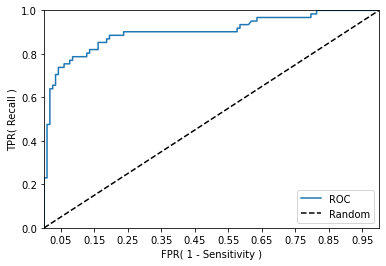

In [55]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

일반적으로 ROC 곡선은 FPR과 TPR의 변화 값을 보는데 이용<br>
분류의 성능 지표로 사용되는 것은 AUC 값 = ROC 곡선 면적
* 1에 가까울수록 좋은 수치
* AUC 수치가 커지려면 FPR이 작은 상태에서 큰 TPR을 얻어야 함. (가파르게 곡선이 증가)
* 가운데 직선은 랜덤 동전던지기 수준이므로 보통의 분류는 0.5 이상의 AUC 값을 가짐.

In [58]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test,pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


sklearn.metrics.roc_auc_score(y_true, y_score, ...)

**Parameters**
* `y_true` : array-like of shape (n_samples,) or (n_samples, n_classes)
True labels or binary label indicators. 
* `y_score` : array-like of shape (n_samples,) or (n_samples, n_classes)
Target scores.
    * In the binary case, it corresponds to an array of shape (n_samples,). Both probability estimates and non-thresholded decision values can be provided. The probability estimates correspond to the probability of the class with the greater label, i.e. `estimator.classes_[1]` and thus `estimator.predict_proba(X, y)[:, 1]`. The decision values corresponds to the output of `estimator.decision_function(X, y)`. 
    * predict_proba()로 호출된 예측 확률 ndarray중 Positive 열에 해당하는 ndarray입니다. 

In [59]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

<span style="color:red">**[질문]**</span><br>
def get_clf_eval(y_test, pred=None, pred_proba=None) : 에서 <br>
    파라미터의 `= None`을 쓰고 안쓰고의 차이는?

## 피마 인디언 당뇨병 예측
<br>

**데이터 세트 구성**
* Pregnancies : 임신횟수
* Glucose : 포도당 부하 검사 수치
* BloodPressure : 혈압
* SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
* Insulin : 혈청 인슐린
* BMI : 체질량 지수
* DiabetesPedigreeFunction : 당뇨 내력 가중치 값
* Age : 나이
* Outcome : 클래스 결정 값 - 당뇨여부(0 또는 1)

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('C:\\Users\\Yujin\\Desktop\\data science\\boostcourse-ds-511-master\\boostcourse-ds-511-master\\data\\diabetes.csv')


In [64]:
print(diabetes_data['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


negative가 상대적으로 많음.

In [65]:
diabetes_data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [66]:
diabetes_data.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [70]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출. 
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=156,stratify=y)
# stratify : stratify=Y로 설정하면 지정한 Data의 비율을 유지한다. 

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741,          F1: 0.6392, AUC:0.7919


C:\Users\Yujin\anaconda3\envs\dsvenv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


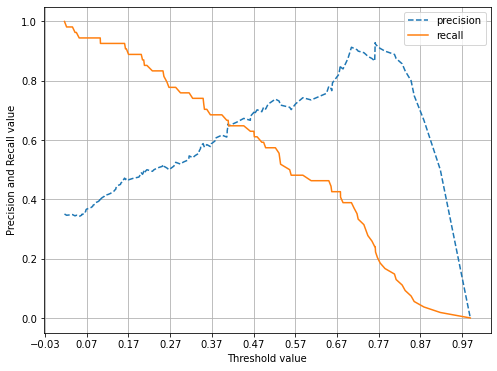

In [72]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test,pred_proba_c1)

재현율을 올리기 위해 정밀도-재현율 곡선을 살펴보면, 임계값이 0.42정도면 균형이 맞을 것 같음.
-> but 두 지표 모두 0.7정도로 낮은 값을 보임. 
-> 임계값 조정 전에 데이터값 먼저 점검.

In [73]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min값이 0으로 되어있는 피처가 많음. -> 포도당 수치가 0일 수 없음.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

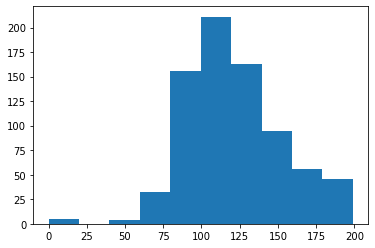

In [74]:
plt.hist(diabetes_data['Glucose'],bins=10) #bin은 막대너비

In [80]:
diabetes_data[diabetes_data['Glucose']== 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [82]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features :
    zero_count = diabetes_data[diabetes_data[feature]== 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))


Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [84]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,diabetes_data[zero_features].mean())

In [85]:
# 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 피처 스케일링을 적용하는 것이 좋음.

X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( ) #각 피처를 정규화(결과 클래스 제외)
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf=LogisticRegression()
lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred,pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,          F1: 0.6804, AUC:0.8433


In [87]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

In [88]:
# 전반적으로 개선되었지만, 재현율은 좀 더 개선이 필요. -> 임계값 0.3->0.5변화시키면서 적절한 값 찾기

thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,          F1: 0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,          F1: 0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,          F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,          F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,          F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,          F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,          F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,          F1: 0.6804, AUC:0.8433


In [89]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

pred_th_048=binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,          F1: 0.6931, AUC:0.8433


<span style="color:red">**[질문]**</span><br>
binarizer클래스를 생성하는 방법 말고, estimator 내부에서 threshold값을 바꿀 수는 없는지?